In [1]:
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import QpixAsic as qpasic
import random
import numpy as np
random.seed(7)

In [2]:
# make this a unit test
qpa = qparray.QpixAsicArray(2, 2, debug=0.0, timeout=1e4, deltaT=2e-6)
qpa.Calibrate(0.00025)
print(qpa._daqNode.hitData.items())
end, counts = 0, 0
while True:
    hit = qpa._daqNode._localFifo.Read()
    if hit is None:
        break
    if hit.wordType != qpasic.AsicWord.EVTEND:
        counts += 1
        print(hit, counts)
    else:
        end += 1

print(f"found daq hits: {qpa._daqNode.daqHits}")
print(f"event end: {end}")

dict_items([('(0, 0)', []), ('(0, 1)', []), ('(1, 0)', []), ('(1, 1)', [])])
(0,0): AsicWord.REGRESP  - 5.351485674359715e-06 1
(0,1): AsicWord.REGRESP  - 1.0502873696709451e-05 2
(1,0): AsicWord.REGRESP  - 1.0897923324942458e-05 3
(1,1): AsicWord.REGRESP  - 1.584918178161636e-05 4
(0,0): AsicWord.REGRESP  - 0.0002573556303356563 5
(0,1): AsicWord.REGRESP  - 0.0002624989372988958 6
(1,0): AsicWord.REGRESP  - 0.00026289606616330426 7
(1,1): AsicWord.REGRESP  - 0.00026783665269519675 8
found daq hits: 16
event end: 8


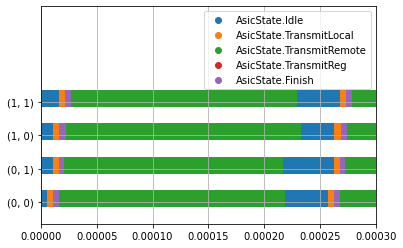

In [3]:
# unit test this based on duration of time out?
qparray.viewAsicState(qpa)

Text(0.5, 1.0, 'ASIC Frequency Error Calculation')

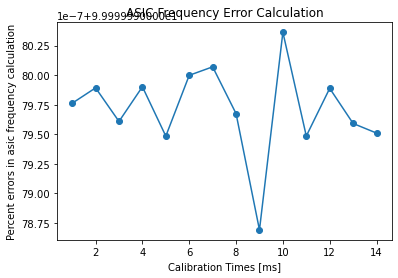

In [4]:
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import random
import numpy as np
random.seed(7) 
# investigate why some random seeds allow you to do several calibrations and others dont, maybe it is with the asic oscillation frequency?

row = 2
col = 2

GuessFreqArray = []
PercDiffArray = {}
Keys = []
CalibrateThroughTimes = np.arange(1, 15) * 1e-3
freq = {}

for number, CalTime in enumerate(CalibrateThroughTimes):
    q = qparray.QpixAsicArray(row, col, debug = 0., deltaT = 1e-6, timeEpsilon = 2e-6)
    q.Calibrate(CalTime)

    guessFrq = {}
    for k, v in q._daqNode.regData.items():
        asic = k
        daqTicks = []
        asicTicks = []
        for daqTick, Byte in v:
            daqTicks.append(daqTick)
            asicTicks.append(Byte.data) # Byte[4] or Byte.data depending what is appended
        if len(asicTicks) < 2:
            print(f'\nno work fo da calibration time {CalTime}: ')
            for asic in q:
                print(f'osc freq: {asic.fOsc}')
                print(f'start time {asic._startTime}')
                print()

        # print("asic ticks:", asicTicks)
        guessFrq[asic] = (asicTicks[-1] - asicTicks[-2]) / (daqTicks[-1] - daqTicks[-2])  * q._daqNode.fOsc
        GuessFreqArray.append(guessFrq[asic])
        # print(f'appending {guessFrq[asic]} for asic {asic}')

    for asic in q:
        key = f"({asic.row}, {asic.col})"
        if key not in Keys: Keys.append(key)
        # print(f"{key} percent diff: {(guessFrq[key] - asic.fOsc) / asic.fOsc * 100:1.2E}")
        percdiff = (guessFrq[key] - asic.fOsc) / asic.fOsc * 100
        if key not in PercDiffArray:
            PercDiffArray[key] = []
        PercDiffArray[key].append(percdiff)

#################################################
## PLOTTING

import pylab as p

plot = np.zeros((len(CalibrateThroughTimes)))
for runs in range(len(CalibrateThroughTimes)):
    somethingcreative = []
    for key in Keys:
        somethingcreative.append(np.absolute(PercDiffArray[key][runs]))
    plot[runs] = sum(somethingcreative) / len(Keys);

p.plot(CalibrateThroughTimes * 1e3, plot, linestyle='-', marker='o');
p.xlabel('Calibration Times [ms]')
p.ylabel('Percent errors in asic frequency calculation')
p.title('ASIC Frequency Error Calculation')

In [5]:
## THIS PROBLEM CAN PROBABLY SOLVED BY MESSING WITH THE TIMEOUT TIME
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import random
import numpy as np

row = 2
col = 2

# CalTimes = np.arange(1, 20) * 1e-3
# WorkingFreq = np.zeros((100000, 4))
# NonWorkingFreq = np.zeros((100000, 4))
# step = 0

# for j in range(1000):
#     random.seed(random.randint(0, 100000))
#     for i in CalTimes:
#         q = qparray.QpixAsicArray(row, col, debug = 0., deltaT = 1e-5, timeEpsilon = 2e-6, timeout=2000)
#         q.Interrogate(interval=i)
#         if q._alert:
#             for index, asic in enumerate(q):
#                 NonWorkingFreq[step, index] = asic.fOsc
#         else:
#             for index, asic in enumerate(q):
#                 WorkingFreq[step, index] = asic.fOsc
#         step+=1

# WorkingFreq = WorkingFreq[NonWorkingFreq[:,0] == 0]
# WorkingFreq = WorkingFreq[WorkingFreq[:, 0] > 0, 0:3] * 1e-6
# NonWorkingFreq = NonWorkingFreq[NonWorkingFreq[:, 0] > 0, 0:3] * 1e-6

# ###################################
# # PLOTTING

# fig = plt.figure(figsize=(10, 10))
# ax = plt.axes(projection='3d')
# ax.set_xlim(43, 58)
# ax.set_xlabel('asic (0, 0) frequency [MHz]')
# ax.set_ylim(43, 58)
# ax.set_ylabel('asic (0, 1) frequency [MHz]')
# ax.set_zlim(43, 58)
# ax.set_zlabel('asic (1, 0) frequency [MHz]')

# ax.plot(*WorkingFreq, marker = 'o', color = 'blue', linestyle = '');
# ax.plot(*NonWorkingFreq, marker = 'o', color = 'red', linestyle = '');
# ax.legend(('working frequency combinations', 'non-working frequency combinations'));
# leg = ax.get_legend()
# leg.legendHandles[0].set_color('blue')
# leg.legendHandles[1].set_color('red')
# plt.show()

# plt.plot(WorkingFreq[:,0], WorkingFreq[:,1], marker = 'o', color = 'blue', linestyle = '')
# plt.plot(NonWorkingFreq[:,0], NonWorkingFreq[:, 1], marker = 'o', color = 'red', linestyle = '')
# plt.xlabel('asic (0, 0) frequency [MHz]')
# plt.ylabel('asic (0, 1) frequency [MHz]')
# plt.show()

timeout 1000.0s works for an array of 1 x 1 asics
timeout 3000.0s works for an array of 2 x 1 asics
timeout 3000.0s works for an array of 2 x 2 asics
timeout 3000.0s works for an array of 3 x 2 asics
timeout 3000.0s works for an array of 3 x 3 asics
timeout 3000.0s works for an array of 4 x 3 asics
timeout 5000.0s works for an array of 4 x 4 asics
timeout 7000.0s works for an array of 5 x 4 asics
timeout 7000.0s works for an array of 5 x 5 asics
timeout 9000.0s works for an array of 6 x 5 asics


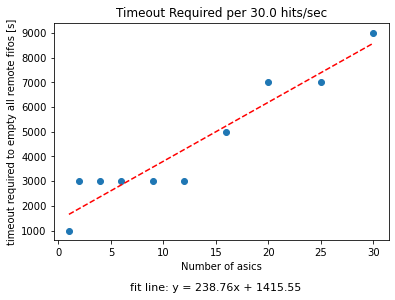

In [12]:
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import random
import numpy as np
import pylab as p
from scipy.optimize import curve_fit as cf
random.seed(7)

DIRECTIONS = ("North", "East", "South", "West")

row = 1
col = 1
iters = 10
WorkingTimeoutArray = np.zeros((iters, 2))
toggle = True
TimeoutArray = np.arange(1, 1000, 2) * 1e3

for tiledim in range(iters):

    for timeout in TimeoutArray:
        timeoutwork=0
        array = qparray.QpixAsicArray(row, col, deltaT=1e-4, timeout=timeout, hitsPerSec=30.)
        array.Interrogate(interval=.2)
        for asic in array:
            for direc in range(4):
                CurSize = asic._remoteFifos[direc]._curSize
                if CurSize > 0:
                    timeoutwork+=1
        if timeoutwork == 0:
            print(f'timeout {timeout}s works for an array of {row} x {col} asics')
            WorkingTimeoutArray[tiledim, 0] = row * col
            WorkingTimeoutArray[tiledim, 1] = timeout
            if toggle:
                row+=1
            else:
                col+=1
            toggle = not(toggle)
            break
    if timeout == TimeoutArray[-1]:
        break

xvalues = WorkingTimeoutArray[:, 0]
yvalues = WorkingTimeoutArray[:, 1]

def FitFunc(x, a, b):
    return a * x + b

popt, pcov = cf(FitFunc, xvalues, yvalues)

p.plot(xvalues, yvalues, marker='o', linestyle='')
p.plot(xvalues, FitFunc(xvalues, *popt), linestyle = '--', color = 'red')
p.title(f'Timeout Required per {array._asics[0][0].randomRate} hits/sec')
p.xlabel('Number of asics')
p.ylabel('timeout required to empty all remote fifos [s]')
txt = f'fit line: y = {popt[0]:2.2f}x + {popt[1]:2.2f}'
p.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=11);

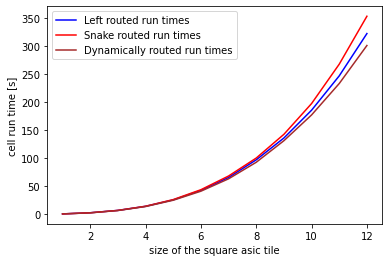

In [1]:
import numpy as np
import time 
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import random
random.seed()
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


FinalSize = 13
LeftRunTimes = np.zeros(FinalSize-1)
SnakeRunTimes = np.zeros(FinalSize-1)
DynamicRunTimes = np.zeros(FinalSize-1)
for route in ['left', 'snake', None]:
    start = time.time()

    Sizes = np.arange(1, FinalSize)

    moveon = False
    timeout = 5e4

    for ind, size in enumerate(Sizes):
        row = size
        col = size
        numOfAsics = row * col
        array = qparray.QpixAsicArray(row, col, deltaT=1e-5, 
            timeout=timeout)

        ## setup
        ## inject hits into asics
        times = np.arange(0, 5, 0.1)
        channels = [[1, 7, 8]] * len(times)
        for asic in array:
            asic.InjectHits(times=times, channels=channels)
        array.Route(route=route, timeout=timeout)
        ## main
        t = 0
        int_frq = 0.5 # interrogate every second
        stop = 5.5  # 100s of data
        while t < stop:
            array.Interrogate(int_frq)
            t += int_frq

        end = time.time()
        t = end - start
        if route == 'left':
            LeftRunTimes[ind] = t
        elif route == None:
            DynamicRunTimes[ind] = t
        else:
            SnakeRunTimes[ind] = t
        # print(f'the time now is {t}')

# for asic in array:
#     key = f'({asic.row}, {asic.col})'
#     print(f'the reg data and hit data for asic {key} is ', end="")
#     print(len(array._daqNode.regData[key]), end=" and ")
#     print(len(array._daqNode.hitData[key]))

# qparray.MakeFifoBars(array)
fig, ax = plt.subplots()
ax.plot(Sizes, LeftRunTimes, color='blue')
ax.plot(Sizes, SnakeRunTimes, color='red')
ax.plot(Sizes, DynamicRunTimes, color='brown')
ax.set(ylabel='cell run time [s]', xlabel='size of the square asic tile')
ax.legend(('Left routed run times', 'Snake routed run times', 'Dynamically routed run times'))


In [12]:
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import random
random.seed()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from QpixAsic import AsicConfig as aconfig
from QpixAsic import AsicDirMask as dirMask

DIRECTIONS = ("North", "East", "South", "West")


Sizes = np.arange(2, 11)
FutileRate_Snake = np.zeros_like(Sizes)
FutileRate_Left = np.zeros_like(Sizes)
FutileRate_Dynamic = np.zeros_like(Sizes)
int_frq = 0.5
timeout = 1.5e4
Rates = np.arange(5, 3000, 5)

for route in [None, 'snake', 'left']:
    for ind, size in enumerate(Sizes):
        if route == None:
            size+=6
        stobit = False
        row = size
        col = size
        for rate in Rates:
        
            array = qparray.QpixAsicArray(row, col, deltaT=1e-5, 
                timeout=timeout, hitsPerSec = 1./1.)
            array.Route(route=route, timeout = timeout)

            #inject the noise in the detectors
            times = np.linspace(0, int_frq, rate)
            channels = [[1, 7, 8]] * len(times)
            for asic in array:
                asic.InjectHits(times=times, channels=channels)

            ## main
            array.Interrogate(int_frq)
                # if array._alert:
                    # print('timeout time is too short')

            # qparray.MakeFifoBars(array)
            for asic in array:
                key = f'({asic.row}, {asic.col})'
                # print(f'the reg data and hit data for asic {key} is ', end="")
                # print(len(array._daqNode.regData[key]), end=" and ")
                # print(len(array._daqNode.hitData[key]), end=" \n")
                for d in range(4):
                    if not(asic._remoteFifos[d]._curSize == 0):
                        print(f'{key} remote fifo in {DIRECTIONS[d]} had {asic._remoteFifos[d]._curSize} events left in a {size}x{size} tile')
                        stobit = True
                if not(asic._localFifo._curSize == 0):
                    print(f'{key} local fifo had {asic._localFifo._curSize} events left in a {size}x{size} tile')
                    stobit = True
                # print(f'the times are {asic._times}')
            
            if stobit:
                # print(f'the rate is {rate}')
                if route == 'snake':
                    FutileRate_Snake[ind] = rate
                if route == 'left':
                    FutileRate_Left[ind] = rate
                if route == None:
                    print(f'putting {rate} in the {ind} position of Dynamic')
                    FutileRate_Dynamic[ind] = rate
                # for asic in array:
                    # print(f'({asic.row}, {asic.col}) local fifo max size = {asic._localFifo._maxSize}\n')
                    # for d in range(4):
                        # print(f'({asic.row}, {asic.col}) {DIRECTIONS[d]} remote fifo max = {asic._remoteFifos[d]._maxSize}\n')
                break
            
            if rate == Rates[-1]:
                if route == 'snake':
                    print(f'{route} routed {size}x{size} asic can take da rate')
                    FutileRate_Snake[ind] = -10
                if route == 'left':
                    print(f'{route} routed {size}x{size} asic can take da rate')
                    FutileRate_Left[ind] = -10
                if route == None:
                    print(f'{route} routed {size}x{size} asic can take da rate')
                    FutileRate_Dynamic[ind] = -10
                break

plt.plot(Sizes, FutileRate_Snake, color = 'red', marker='o')
plt.plot(Sizes, FutileRate_Left, color = 'blue', marker='.')
plt.plot(Sizes + 6, FutileRate_Dynamic, color = 'brown', marker='*')
plt.title(f'Maximum rate of noise at {int_frq}s interrogation and timeout={timeout:2E}')
plt.xlabel('Size of ASIC tile in nxn')
plt.ylabel(f'Maximum hits evenly spaced in {int_frq}s')

plt.legend(('Snake', 'Left', 'Dynamic'))

(0, 0) remote fifo in East had 7 events left in a 8x8 tile
putting 5 in the 0 position of Dynamic
(0, 0) remote fifo in East had 14 events left in a 9x9 tile
(0, 1) remote fifo in South had 10 events left in a 9x9 tile
putting 5 in the 1 position of Dynamic
(0, 0) remote fifo in East had 27 events left in a 10x10 tile
(0, 0) remote fifo in South had 13 events left in a 10x10 tile
(0, 1) remote fifo in East had 3 events left in a 10x10 tile
putting 5 in the 2 position of Dynamic
(0, 0) remote fifo in East had 24 events left in a 11x11 tile
(0, 0) remote fifo in South had 21 events left in a 11x11 tile
(0, 1) remote fifo in East had 6 events left in a 11x11 tile
(0, 2) remote fifo in East had 2 events left in a 11x11 tile
(0, 3) remote fifo in South had 10 events left in a 11x11 tile
putting 5 in the 3 position of Dynamic
(0, 0) remote fifo in South had 12 events left in a 12x12 tile
(1, 0) remote fifo in East had 27 events left in a 12x12 tile
(1, 0) remote fifo in South had 9 events le

KeyboardInterrupt: 

In [11]:
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import random
random.seed()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from QpixAsic import AsicConfig as aconfig
from QpixAsic import AsicDirMask as dirMask

stobit = False
size = 7
for rate in np.arange(1000, 50000, 1000):
    print(f'the rate is now {rate}')
    array = qparray.QpixAsicArray(size, size, deltaT=1e-5, timeout = 1.5e4)

    for asic in array:
        times = np.linspace(0, 0.5, rate)
        chan = [[1]] * len(times)
        asic.InjectHits(times=times, channels=chan)

    array.Interrogate(0.5)

    for asic in array:
        key = f'({asic.row}, {asic.col})'
        # print(f'the reg data and hit data for asic {key} is ', end="")
        # print(len(array._daqNode.regData[key]), end=" and ")
        # print(len(array._daqNode.hitData[key]), end=" \n")
        for d in range(4):
            if not(asic._remoteFifos[d]._curSize == 0):
                print(f'{key} remote fifo in {DIRECTIONS[d]} had {asic._remoteFifos[d]._curSize} events left in a {size}x{size} tile')
                print(f'the rate is {rate}')
                stobit = True
        if not(asic._localFifo._curSize == 0):
            print(f'{key} local fifo had {asic._localFifo._curSize} events left in a {size}x{size} tile')
            print(f'the rate is {rate}')
            stobit = True
    
    if stobit:
        break

the rate is now 1000
the rate is now 2000
the rate is now 3000
the rate is now 4000
the rate is now 5000
the rate is now 6000
the rate is now 7000
the rate is now 8000
the rate is now 9000
the rate is now 10000
the rate is now 11000
(0, 0) remote fifo in East had 1 events left in a 7x7 tile
the rate is 11000


putting 250.0 in the 0 position of snake
putting 250.0 in the 1 position of snake
putting 250.0 in the 2 position of snake
putting 250.0 in the 3 position of snake
putting 250.0 in the 4 position of snake
putting 250.0 in the 5 position of snake
putting 250.0 in the 6 position of snake
putting 250.0 in the 7 position of snake
putting 250.0 in the 8 position of snake
putting 250.0 in the 0 position of left
putting 250.0 in the 1 position of left
putting 250.0 in the 2 position of left
putting 250.0 in the 3 position of left
putting 250.0 in the 4 position of left
putting 250.0 in the 5 position of left
putting 250.0 in the 6 position of left
putting 250.0 in the 7 position of left
putting 250.0 in the 8 position of left
putting 250.0 in the 0 position of None
putting 250.0 in the 1 position of None
putting 250.0 in the 2 position of None
putting 250.0 in the 3 position of None
putting 250.0 in the 4 position of None
putting 250.0 in the 5 position of None
putting 250.0 in the 6 position

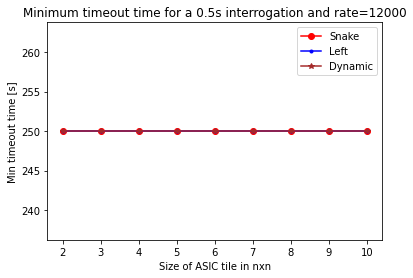

In [3]:
#dynamic routing can take very high rates 
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import random
random.seed()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from QpixAsic import AsicConfig as aconfig
from QpixAsic import AsicDirMask as dirMask

DIRECTIONS = ("North", "East", "South", "West")


Sizes = np.arange(2, 11)
GoodTiming_Snake = np.zeros_like(Sizes)
GoodTiming_Left = np.zeros_like(Sizes)
GoodTiming_Dynamic = np.zeros_like(Sizes)
int_frq = 0.5
Timeoutes = np.arange(250, 1e7, 250)
rate = 12000

for route in ['snake', 'left', None]:
    for ind, size in enumerate(Sizes):
        row = size
        col = size
        for timeout in Timeoutes:   
            stobit = False
            array = qparray.QpixAsicArray(row, col, deltaT=1e-5, 
                timeout=timeout, hitsPerSec = 1./1.)
            array.Route(route=route, timeout = timeout)

            #inject the noise in the detectors
            times = np.linspace(0, int_frq, rate)
            channels = [[1, 7, 8]] * len(times)
            for asic in array:
                asic.InjectHits(times=times, channels=channels)

            ## main
            array.Interrogate(int_frq)
                # if array._alert:
                    # print('timeout time is too short')

            # qparray.MakeFifoBars(array)
            for asic in array:
                key = f'({asic.row}, {asic.col})'
                for d in range(4):
                    if (asic._remoteFifos[d]._curSize == 0):
                        # print(f'{key} remote fifo in {DIRECTIONS[d]} had {asic._remoteFifos[d]._curSize} events left in a {size}x{size} tile')
                        stobit = True
                if (asic._localFifo._curSize == 0):
                    # print(f'{key} local fifo had {asic._localFifo._curSize} events left in a {size}x{size} tile')
                #    print(f'the asics timeout is {asic._timeout}') 
                   stobit = True
            
            if stobit:
                if route == 'snake':
                    print(f'putting {timeout} in the {ind} position of {route}')
                    GoodTiming_Snake[ind] = timeout
                elif route == 'left':
                    print(f'putting {timeout} in the {ind} position of {route}')
                    GoodTiming_Left[ind] = timeout
                elif route == None:
                    print(f'putting {timeout} in the {ind} position of {route}')
                    GoodTiming_Dynamic[ind] = timeout
                break
            
            if timeout == Timeoutes[-1]:
                if route == 'snake':
                    GoodTiming_Snake[ind] = -5
                elif route == 'left':
                    GoodTiming_Left[ind] = -5
                elif route == None:
                    GoodTiming_Dynamic[ind] = -5
                break

plt.plot(Sizes, GoodTiming_Snake, color = 'red', marker='o')
plt.plot(Sizes, GoodTiming_Left, color = 'blue', marker='.')
plt.plot(Sizes, GoodTiming_Dynamic, color = 'brown', marker='*')
plt.title(f'Minimum timeout time for a {int_frq}s interrogation and rate={rate}')
plt.xlabel('Size of ASIC tile in nxn')
plt.ylabel(f'Min timeout time [s]')

plt.legend(('Snake', 'Left', 'Dynamic'))


In [9]:
random.seed(7)

times = [4, 9, 8,2,4,5,1,6]

pixels = []
[pixels.append([]) for i in range(len(times))]
for i in range(len(times)):
    NumOfChan = int(np.absolute(np.ceil(random.gauss(1.5, 2))))
    for channels in range(NumOfChan):
        pixels[i].append(random.randint(0, 16))
print(f'times is {times}')
print(f'pixels is {pixels}')

timesextendo = [0, 1, 2, 3]
times.extend(timesextendo)
pixectendo = [[1, 7, 8]] * len(timesextendo)
pixels.extend(pixectendo)

times, pixels = zip(*sorted(zip(times, pixels)))
times = [*times]
pixels = [*pixels]
print(times)
print(pixels)

times is [4, 9, 8, 2, 4, 5, 1, 6]
pixels is [[1], [2, 3, 11], [6, 1], [], [7, 2, 13, 1], [3, 7, 1], [], [7]]
[0, 1, 1, 2, 2, 3, 4, 4, 5, 6, 8, 9]
[[1, 7, 8], [], [1, 7, 8], [], [1, 7, 8], [1, 7, 8], [1], [7, 2, 13, 1], [3, 7, 1], [7], [6, 1], [2, 3, 11]]
